In [1]:
# !pip install numpy
# !pip install scipy
# !pip install torch
# !pip install matplotlib

In [2]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
gpu = torch.device("cuda:0")
print(torch.cuda.get_device_name(0))

# Use smaller network for testing - ex 2000 neurons
# Even for the project, doing it for 10^6 neurons would take too long
# Problem this creates: test network is denser than actual network b/c we have 10^3 neurons but 10^2 connections per neuron
num_neurons = 2000
num_i = int(0.1 * num_neurons)
num_e = int(0.9 * num_neurons)

# Num excitatory inputs and inhibitory inputs to each neuron (in reality it should be 500 but we reduce it here to make things faster)
k = 100

# Number of olfactory bulb channels (glomeruli) to each neuron
D = 10 ** 3
# For each neuron, how many glomeruli inputs it receives (should be 10^2)
num_channel_inputs = 100

# Channel signal if not active for odor a
i_0 = 2.
# Channel signal if active for odor a
i_1 = 10.
# Probability that a channel is active for an odor a
f = 0.1
# Number of odors
P = 16
# Novel activity is up to P // 2, and familiar activity is after
novel_inds = torch.arange(0, P // 2)
familiar_inds = torch.arange(P // 2, P)

NVIDIA GeForce RTX 3060


In [4]:
# Creates sparse adjacency matrix with the given probability of edge connection and size mxn
def create_adj_matrix(p, m, n):
    # num_connections = int(p * m * n)
    # m_coords = torch.randint(0, m, (num_connections,))
    # n_coords = torch.randint(0, n, (num_connections,))
    # indices = torch.vstack((m_coords, n_coords))
    # values = torch.ones(num_connections)
    # A_mn = torch.sparse_coo_tensor(indices, values, (m, n))
    probs = torch.ones(m, n) * p
    A_mn = torch.bernoulli(probs)
    return A_mn

In [5]:
# New way of generating correlations between odors: we want different sets of odors to be correlated differently, so that when we subtract each neuron's mean activity over odors, it doesn't cancel out the variation between odors (if all the odors are correlated the same, they will tend to produce similar values for a single neuron and therefore subtracting by the mean will remove these values and only leave small fluctuations)
# So we sample a small set of odors P' and make them linearly independent, and then by multiplying by a P'x P gaussian matrix we project into mitral cell activity space for all P odors, basically making the P odors a linear combination of the set of P' odors (the smaller P' is, the more correlated the resulting set of P odors will be)
# We also scale the variance depending on how small P' is, so we will maintain differently correlated odors, just with higher total correlation if P' is small

In [6]:
P_prime = 4
def correlated_mitral_activity():
    # Each of the P' odors is independent (correlation of 0)
    sigma_p_prime = torch.zeros((P_prime, P_prime)).fill_diagonal_(1)
    dist = torch.distributions.MultivariateNormal(torch.zeros(P_prime), sigma_p_prime)
    p_prime_activity = dist.sample(torch.Size([D]))
    var = 1 / P_prime
    projection = torch.normal(torch.zeros((P_prime, P)), torch.ones(P_prime, P) * np.sqrt(var))
    activity = p_prime_activity @ projection
    return activity.to(gpu)

In [7]:
# Takes in mitral activity I and computes feedforward activity h_bar_ff
def compute_feedforward_activity(I):
    # Probability that a channel weight will be nonzero
    p = num_channel_inputs / D
    # Only the first 0.9 * n rows should have this bernoulli number, the rest should be 0 b/c they don't receive a channel input
    # Check whether each neuron still receives ~10^2 nonzero inputs or what the distribution actually looks like
    # Because when we calculate the adjacency matrix we don't go by row (e.g ensuring each neuron has these ~10^2 connections)
    # Alternative: sample from Binomial distribution w/ mean 100
    # The output n for each row is the number of nonzero inputs, and you choose a random subset n of the indices for that row and make them 1
    with torch.device(gpu):
        a = create_adj_matrix(p, num_e, D)
        # Inhibitory neurons don't receive channel input
        # This is the first simplification, where we neglect the first inhibitory layer I_ff
        b = torch.zeros(size=(num_i, D))
        W_ff = torch.cat(tensors=(a, b), dim=0)
        
        h_ff = (W_ff @ I) * (1 / np.sqrt(num_channel_inputs))
        h_bar_ff = torch.zeros_like(h_ff)
        h_bar_ff[:num_e] = h_ff[:num_e] - torch.mean(h_ff[:num_e], dim=0, keepdim=True)
    return h_bar_ff

In [8]:
def compute_initial_recurrent_weights():
    k_ee = k_ei = k_ie = k_ii = k
    #p_ee = k_ee / num_e
    # k inhibitory inputs to that e neuron, out of num_i total inhibitory neurons gives the connection probability per neuron
    p_ei = k_ei / num_i
    p_ie = k_ie / num_e
    #p_ii = k_ii / num_i
    
    # Constants
    #w_ee = 0.1
    w_ei = 0.2
    w_ie = 0.5
    #w_ii = 0.3
    # Ignore ee and ii weights for now:
    p_ee = p_ii = w_ee = w_ii = 0
    with torch.device(gpu):
        W_ee = create_adj_matrix(p_ee, num_e, num_e) * w_ee
        W_ei = create_adj_matrix(p_ei, num_e, num_i) * -w_ei
        W_ie = create_adj_matrix(p_ie, num_i, num_e) * w_ie
        W_ii = create_adj_matrix(p_ii, num_i, num_i) * -w_ii
        
        # Concat
        W_1 = torch.cat(tensors=(W_ee, W_ei), dim=1)
        W_2 = torch.cat(tensors=(W_ie, W_ii), dim=1)
        W_rec = torch.cat(tensors=(W_1, W_2), dim=0)
    
    return W_rec

In [9]:
# Computes activation threshold for neurons, based on the standard deviation of their firing rates across odors
# This average standard deviation, multiplied by theta=2, ensures that each neuron will fire for only 5% of odors
def compute_threshold(total_input, theta):
    # For now, use diff thresholds for each neuron
    center = torch.mean(total_input, dim=1, keepdim=True)
    shift = torch.std(total_input, dim=1, keepdim=True)
    #threshold = center + (theta * shift)
    threshold = torch.ones_like(total_input) * theta
    # Since inhibitory neurons are linear
    threshold[num_e:, :] = 0
    return threshold

In [10]:
# ReLU for excitatory, linear for inhibitory
def neuron_activations(X):
    # Mask to keep excitatory
    mask1 = torch.ones((num_neurons, 1), device=gpu)
    mask1[num_e:, :] = 0
    # Mask to keep inhibitory
    mask2 = torch.zeros((num_neurons, 1), device=gpu)
    mask2[num_e:, :] = 1
    return (torch.relu(X) * mask1) + (X * mask2)

In [11]:
# Computes R for each odor, with the activation threshold theta
def compute_piriform_response(h_bar_ff, W_rec, threshold_mult):
    # The coefficient of x_bar
    tau = 1
    # time step
    dt = 0.1
    # Number of time steps
    T = 200
    
    # Initial condition where states are gaussian
    mu_0 = 0.
    sigma_0 = 0.2
    X_0 = torch.normal(mu_0, sigma_0, size=(num_neurons, P))
    X = X_0.to(gpu)
    
    #pts = []
    for i in range(T-2):
        with torch.no_grad():
            part1 = -1 * X
            part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
            part3 = h_bar_ff
            dXdt = (1 / tau) * (part1 + part2 + part3)
            X = X + (dXdt * dt)
        # Look at convergence pattern for first odor, assuming that it'll
        # be similar across odors (since they are all independent)
        #pts.append(torch.mean(dXdt, dim=0)[0].item())
   
    # On the last 2 iterations only, track the gradient
    X.requires_grad_(True)
    
    for j in range(2):
        part1 = -1 * X
        part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
        part3 = h_bar_ff
        dXdt = (1 / tau) * (part1 + part2 + part3)
        X = X + (dXdt * dt)
    
    # The total input to the neuron at this last time step (should be equivalent to the resulting value of X after this time step, since dxdt = 0 after the recurrent network converges)
    total_input = part2 + part3
    threshold = compute_threshold(total_input, 0)
    
    # Plot derivatives to see if state converged
    # plt.plot(torch.arange(T-2), pts)
    # plt.show()
    R = neuron_activations(X - threshold)
    
    return R

In [12]:
# Compute dimensionality of activity matrix R for either novel or familiar
def compute_dim(R, odor_inds):
    # Only compute for the excitatory neurons (b/c those are the ones that send signals to rest of brain
    C = torch.cov(R[:num_e, odor_inds[0]:odor_inds[-1]])
    dim = torch.trace(C) ** 2 / torch.trace(C @ C)
    return dim

# trace() is invariant for cyclic permutations of a matrix
# Since C is symmetric, it can be orthogonally diagonalized into UDU^T where U is composed of orthonormal eigenvectors, U^T = U^-1, and D is a diagonal matrix of eigenvalues
# therefore, trace(C) = trace(UDU^T) = trace(DU^TU) = trace(D) = sum(eigvals of C)
# Similarly for the denominator, we need to compute the sum of the squared eigenvalues, which is trace(D^2). trace(D^2) = trace(D^2U^TU) = trace(UD^2U^T) = trace((UDU^T)^2)) [by the property of matrix exponentiation for a diagonalizable matrix] = trace(C^2) = trace(C @ C)

In [13]:
# Dimensionalities should be similar before performing plasticity, upper bound on dimensionality is 8 b/c there are 8 odors each for novel/familiar (this is the rank of the cov matrix)
# Measures how many orthogonal directions in neuron space are needed to explain the set of odors (the max number of orthogonal directions is the number of neurons themselves)
# print(C_novel0)
# print(C_familiar0)

In [14]:
def odor_corrs(R):
    # We don't care about the actual responses per odor, just about a neuron's fluctuations around its mean response across odors
    R_adjusted = R[:num_e] - torch.mean(R[:num_e], dim=1, keepdim=True)
    # Each odor becomes a variable, because we want to calculate correlations between them across neurons
    R_adjusted.t_()
    # Like cov but divides by standard deviations, effectively normalizing the values (the diagonals of the resulting matrix become 1)
    sigma_E = torch.corrcoef(R_adjusted)
    # We only care about the correlations between the familiar odors
    familiar_corrs = sigma_E[P//2:P, P//2:P] - torch.eye(P // 2, device=gpu)
    corr_sum = torch.sum(familiar_corrs ** 2)
    avg_corr = torch.mean(torch.abs(familiar_corrs))
    
    return corr_sum, avg_corr

In [15]:
# Sparsity per odor, across all (E) neurons
def sparsity_per_odor(R):
    # If we have zero responses
    sp_per_odor = 1 - ((torch.sum(R[:num_e], dim=0) ** 2) / (num_e * (torch.sum(R[:num_e] ** 2, dim=0))))
    # Sparsity nan means that the responses were all 0 for an odor, meaning that its max sparsity of 1
    sp_per_odor = torch.nan_to_num(sp_per_odor, nan=1.0)
    return sp_per_odor

# Sparsity per (E) neuron, across a given odor family
def sparsity_per_neuron(R, odor_inds):
    sp_per_neuron = 1 - (
                (torch.sum(R[:num_e, odor_inds], dim=1) ** 2) / (P * torch.sum(R[:num_e, odor_inds] ** 2, dim=1)))
    return sp_per_neuron

In [16]:
# Try to minimize the correlations between values
def loss_fn(R, W, ie_update_inds, ei_update_inds, lambda_corr, lambda_w, lambda_mu, lambda_var, lambda_sp, do_print):
    corr_sum, avg_corr = odor_corrs(R)
    corr_loss = (1 / ((P // 2) ** 2)) * corr_sum
    corr_term = lambda_corr * corr_loss
    
    means = torch.mean(R[:num_e], dim=0)
    means_novel = torch.mean(means[novel_inds])
    means_familiar = torch.mean(means[familiar_inds])
    mu_term = lambda_mu * (((means_familiar - means_novel) / (means_novel + means_familiar)) ** 2)
    mu_term = torch.nan_to_num(mu_term, nan=0.)
    
    vars = torch.var(R[:num_e], dim=0)
    var_novel = torch.mean(vars[novel_inds])
    var_familiar = torch.mean(vars[familiar_inds])
    var_term = lambda_var * (((var_familiar - var_novel) / (var_novel + var_familiar)) ** 2)
    var_term = torch.nan_to_num(var_term, nan=0.)
    
    sparsities = sparsity_per_odor(R)
    spars_novel = torch.mean(sparsities[novel_inds])
    spars_familiar = torch.mean(sparsities[familiar_inds])
    # All sparsities are 0, so this regularization term is at its highest value
    if (spars_novel + spars_familiar) < 1e-6:
        # Sparsities are technically the  same so the term shouldn't contribute to loss
        spars_term = 0
    else:
        spars_term = lambda_sp * (((spars_familiar - spars_novel) / (spars_novel + spars_familiar)) ** 2)

    ie_weight_reg = torch.sum((W[ie_update_inds] - w_ie) ** 2) / (num_i * k)
    ei_weight_reg = torch.sum((W[ei_update_inds] - w_ei) ** 2) / (num_e * k)

    # IE and EI have same weight regularization term for now
    ie_weight_term = lambda_w * ie_weight_reg
    ei_weight_term = lambda_w * ei_weight_reg
    
    if do_print:
        # print("Avg Corr: %.4f, Corr: %.4f, Mu: %.4f, Var: %.4f, Sparsity: %.4f" % (avg_corr, corr_term, mu_term, var_term, spars_term))
        print("Avg Corr: %.4f, Corr: %.4f, Sparsity: %.4f, IE: %.4f, EI: %.4f" % (avg_corr, corr_term, spars_term, ie_weight_term, ei_weight_term))
    
    loss = corr_term + mu_term + var_term + spars_term + ie_weight_term + ei_weight_term
    return loss

In [17]:
# Detaching vs zero grad - should detach because we have a term dependent on the previous model iteration which isn't zero but some constant gradient, accumulated from that model output

In [18]:
def loss_after_odors(W_rec: torch.Tensor, ie_update_inds, ei_update_inds, h_bar_ff: torch.Tensor, threshold_mult, lambda_corr, lambda_w, lambda_mu, lambda_var, lambda_sp, do_print):   
    R_new = compute_piriform_response(h_bar_ff, W_rec, threshold_mult)
    loss = loss_fn(R_new, W_rec, ie_update_inds, ei_update_inds, lambda_corr, lambda_w, lambda_mu, lambda_var, lambda_sp, do_print)
    
    return loss, R_new

In [19]:
# To check theoretical minimum odor correlations, generate random gaussian matrix of shape (num_neurons, 8) and this is what the minimum correlation should be
# mu = torch.zeros((num_neurons, 16))
# std = torch.ones((num_neurons, 16))
# R_random = torch.normal(mu, std)
# loss_min = loss_fn(R_random)
# Theoretical min of 0.05

In [20]:
def verify_initial_activities():
    runs = 50
    avg_corrs = torch.empty((runs,))
    total_losses = torch.empty((runs,))
    for i in range(runs):
        with torch.no_grad():
            a = correlated_mitral_activity()
            h = compute_feedforward_activity(a)
            w = compute_initial_recurrent_weights()
            r = compute_piriform_response(h, w, 0)
        total_loss, avg_corr = odor_corrs(r)
        print(f"Loss: {total_loss.item()}, Avg Corr: {avg_corr}")
        total_losses[i] = total_loss
        avg_corrs[i] = avg_corr
    plt.hist(avg_corrs, bins=15)
    plt.show()

In [21]:
def get_update_inds(post, pre, W):
    weights_slice = W[post[0]:post[1], pre[0]:pre[1]]
    inds = torch.nonzero(weights_slice, as_tuple=True)
    update_inds = (inds[0] + post[0], inds[1] + pre[0])
    
    return update_inds

In [24]:
import torch.optim as optim
epochs_inner = 1000
# Number of standard deviations from mean, we are trying 0 b/c 1 and 2 is too sparse
threshold_multiplier = 0

lambda_corr, lambda_w, lambda_mu, lambda_var, lambda_sp = 1, 0, 0, 0, 0

mult = 100
w_ie = 0.5
ie_max_weight = mult * w_ie
ie_min_weight = 0

w_ei = -0.2
ei_max_weight = 0
ei_min_weight = mult * w_ei

ie_post = (num_e, num_neurons)
ie_pre = (0, num_e)

ei_post = (0, num_e)
ei_pre = (num_e, num_neurons)


corrs = torch.empty((epochs_inner,))

def train_model():
    W_initial = compute_initial_recurrent_weights()
    W_trained = W_initial.clone().to(gpu)
    W_trained.requires_grad_(True)
    
    ie_update_inds = get_update_inds(ie_post, ie_pre, W_trained)
    ei_update_inds = get_update_inds(ei_post, ei_pre, W_trained)
    
    # Only update the relevant weights
    def w_hook(grad):
        new_grad = torch.zeros_like(grad)
        new_grad[ie_update_inds] = grad[ie_update_inds]
        new_grad[ei_update_inds] = grad[ei_update_inds]
        return new_grad
    
    W_trained.register_hook(w_hook)
    optimizer = optim.Adam([W_trained], lr=1e-2)
    # SGD requires much higher LR than Adam
    #optimizer = optim.SGD([W_trained], lr=1e2)
    
    i = correlated_mitral_activity()
    hbar_ff = compute_feedforward_activity(i)   
    R_initial = compute_piriform_response(hbar_ff, W_initial, threshold_multiplier)
    R_trained = R_initial.clone()
    print(f"Initial loss: \t", end="")
    loss_fn(R_initial, W_initial, ie_update_inds, ei_update_inds, lambda_corr, lambda_w, lambda_mu, lambda_var, lambda_sp, do_print=True)
    
    clamp_min = torch.zeros_like(W_trained)
    # I->E weights have lower negative bound
    clamp_min[ei_update_inds] = ei_min_weight
    # E->I weights are only positive
    clamp_min[ie_update_inds] = ie_min_weight
    clamp_max = torch.zeros_like(W_trained)
    # E->I weights have higher positive bound
    clamp_max[ie_update_inds] = ie_max_weight
    # I->E weights are only negative
    clamp_max[ei_update_inds] = ei_max_weight

    num_samples = 1000
    W_tracked = torch.empty((epochs_inner, num_samples, 2))
    ie_track_inds = torch.randperm(len(ie_update_inds[0]))[:num_samples]
    ei_track_inds = torch.randperm(len(ei_update_inds[0]))[:num_samples]
    
    for i in range(epochs_inner):
        do_print=False
        if i % 100 == 0:
            print(f"Epoch {i}: \t", end="")
            do_print = True
        
        loss, R_trained = loss_after_odors(W_trained, ie_update_inds, ei_update_inds, hbar_ff, threshold_multiplier, lambda_corr, lambda_w, lambda_mu, lambda_var, lambda_sp, do_print)
        
        corrs[i] = odor_corrs(R_trained)[1]
        
        W_tracked[i, :, 0] = W_trained[ie_update_inds][ie_track_inds].detach()
        W_tracked[i, :, 1] = W_trained[ei_update_inds][ei_track_inds].detach()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        with torch.no_grad():
            W_trained.clamp_(min=clamp_min, max=clamp_max) 

            
    return ie_update_inds, ei_update_inds, W_initial, W_trained, W_tracked, R_initial, R_trained

In [25]:
ie_update_inds, ei_update_inds, W_initial, W_trained, W_tracked, R_initial, R_trained = train_model()

Initial loss: 	Avg Corr: 0.2384, Corr: 0.0943, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 0: 	Avg Corr: 0.2384, Corr: 0.0943, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 100: 	Avg Corr: 0.0123, Corr: 0.0003, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 200: 	Avg Corr: 0.0043, Corr: 0.0000, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 300: 	Avg Corr: 0.0026, Corr: 0.0000, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 400: 	Avg Corr: 0.0019, Corr: 0.0000, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 500: 	Avg Corr: 0.0014, Corr: 0.0000, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 600: 	Avg Corr: 0.0011, Corr: 0.0000, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 700: 	Avg Corr: 0.0009, Corr: 0.0000, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 800: 	Avg Corr: 0.0007, Corr: 0.0000, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000
Epoch 900: 	Avg Corr: 0.0006, Corr: 0.0000, Sparsity: 0.0000, IE: 0.0000, EI: 0.0000


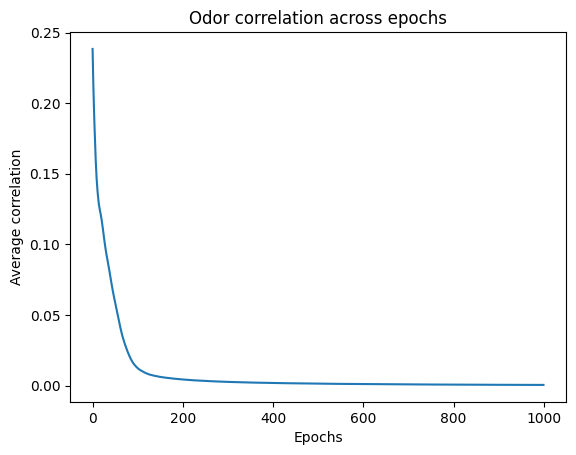

In [26]:
with torch.no_grad():
    plt.plot(torch.arange(epochs_inner), corrs)
    plt.xlabel("Epochs")
    plt.ylabel("Average correlation")
    plt.title("Odor correlation across epochs")

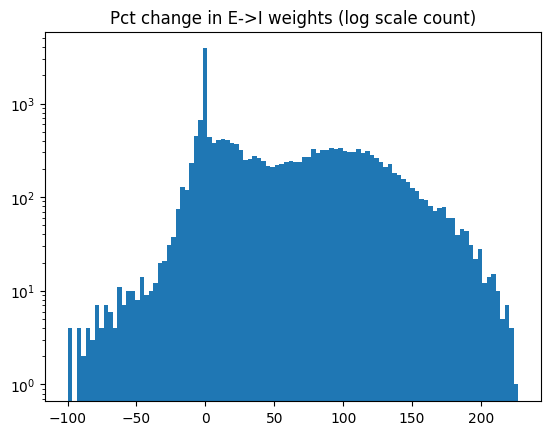

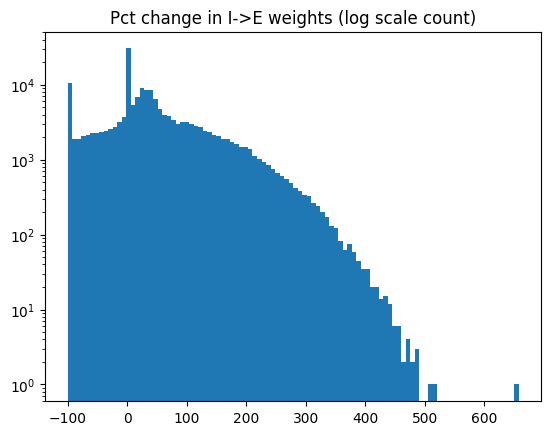

In [27]:
with torch.no_grad():
    plt.hist(((W_trained[ie_update_inds].cpu() - w_ie) / w_ie) * 100, bins=100)
    plt.title("Pct change in E->I weights (log scale count)")
    plt.yscale("log")
    plt.show()
    plt.hist(((W_trained[ei_update_inds].cpu() - w_ei) / w_ei) * 100, bins=100)
    plt.title("Pct change in I->E weights (log scale count)")
    plt.yscale("log")
    plt.show()

In [32]:
print(torch.sum(torch.abs((W_trained[ie_update_inds].cpu() - w_ie) / w_ie) < 1e-5) / len(ie_update_inds[0]))
print(torch.sum(torch.abs((W_trained[ei_update_inds].cpu() - w_ei) / w_ei) < 1e-5) / len(ei_update_inds[0]))

tensor(0.1413)
tensor(0.1387)


In [ ]:
spars_initial = sparsity_per_odor(R_initial)
initial_spars_diff = torch.abs(torch.mean(spars_initial[novel_inds]) - torch.mean(spars_initial[familiar_inds]))
spars_final = sparsity_per_odor(R_trained)
final_spars_diff = torch.abs(torch.mean(spars_final[novel_inds]) - torch.mean(spars_final[familiar_inds]))
spars_change = ((final_spars_diff - initial_spars_diff) / initial_spars_diff) * 100

print(spars_change)

tensor(276.5285, device='cuda:0', grad_fn=<MulBackward0>)


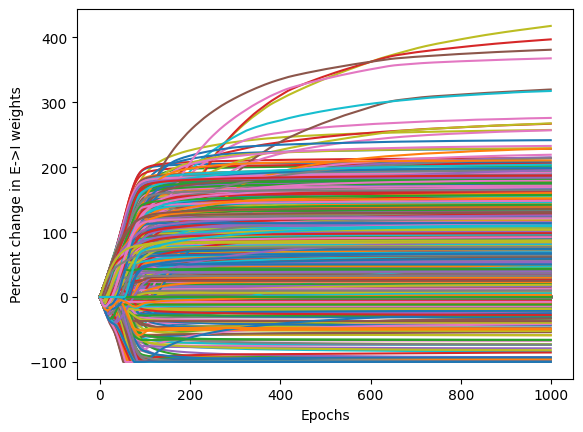

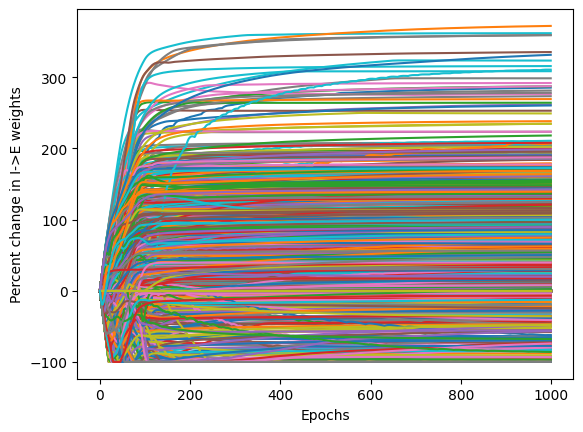

In [ ]:
with torch.no_grad():
    pct_change = ((W_tracked[:, :, 0] - w_ie) / w_ie) * 100
    plt.plot(pct_change)
    plt.xlabel("Epochs")
    plt.ylabel("Percent change in E->I weights")
    plt.show()
    
with torch.no_grad():
    pct_change = ((W_tracked[:, :, 1] - w_ei) / w_ei) * 100
    plt.plot(pct_change)
    plt.xlabel("Epochs")
    plt.ylabel("Percent change in I->E weights")
    plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

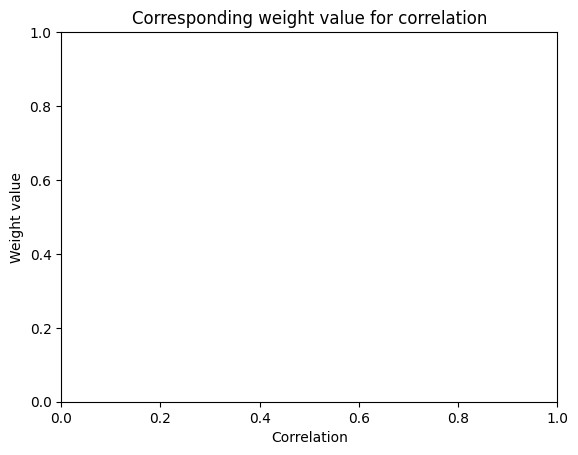

In [ ]:
with torch.no_grad():
    initial_corrs = torch.corrcoef(R_initial)[ie_update_inds]
    initial_corrs, inds = torch.sort(initial_corrs)
    plt.title("Corresponding weight value for correlation")
    plt.xlabel("Correlation")
    plt.ylabel("Weight value")
    plt.scatter(initial_corrs, W_initial[ie_update_inds][inds])

In [ ]:
with torch.no_grad():
    final_corrs = torch.corrcoef(R_trained)[ie_update_inds]
    final_corrs, inds = torch.sort(final_corrs)
    plt.title("Corresponding weight value for correlation")
    plt.xlabel("Correlation")
    plt.ylabel("Weight value")
    plt.scatter(final_corrs, W_trained[ie_update_inds][inds])

In [ ]:
with torch.no_grad():
    plt.title("Distribution of correlations between neurons")
    plt.hist(initial_corrs, label="Before plasticity")
    plt.hist(final_corrs, label="After plasticity")
    plt.legend()
    plt.show()

In [ ]:
# with torch.no_grad():
#     sp_per_odor_0 = sparsity_per_odor(R_initial)
#     sp_per_odor_f = sparsity_per_odor(R_trained)
# 
#     sp_per_neuron_novel_0 = sparsity_per_neuron(R_initial, novel_inds)
#     sp_per_neuron_familiar_0 = sparsity_per_neuron(R_initial, familiar_inds)  
#     sp_per_neuron_novel_f = sparsity_per_neuron(R_trained, novel_inds)
#     sp_per_neuron_familiar_f = sparsity_per_neuron(R_trained, familiar_inds)
#     
#     plt.hist(sp_per_neuron_novel_0, cumulative=True, bins=num_e, histtype="step", label="Novel, before plasticity")
#     plt.hist(sp_per_neuron_familiar_0, cumulative=True, bins=num_e, histtype="step", label="Familiar, before plasticity")
#     plt.hist(sp_per_neuron_novel_f, cumulative=True, bins=num_e, histtype="step", label="Novel, after plasticity")
#     plt.hist(sp_per_neuron_familiar_f, cumulative=True, bins=num_e, histtype="step", label="Familiar, after plasticity")
#     plt.legend()
#     plt.show()
    

In [ ]:
def compute_model_stats():
    runs = 10
    spars_per_odor_0 = torch.empty((runs, P))
    spars_per_odor_f = torch.empty((runs, P))
    # Difference in sparsity per neuron (either across the neuron's novel or familiar responses) measured before and after training
    spars_per_neuron_diff_0 = torch.empty((runs, num_e))
    spars_per_neuron_diff_f = torch.empty((runs, num_e))
    for i in range(runs):
        print(f"Run {i}")
        _, _, _, _, _, R_initial, R_trained = train_model()
        spars_per_odor_f[i, :] = sparsity_per_odor(R_initial)
        spars_per_odor_0[i, :] = sparsity_per_odor(R_trained)
        
        spars_per_neuron_diff_0[i, :] = sparsity_per_neuron(R_initial, familiar_inds) - sparsity_per_neuron(R_initial, novel_inds)
        spars_per_neuron_diff_f[i, :] = sparsity_per_neuron(R_trained, familiar_inds) - sparsity_per_neuron(R_trained, novel_inds)
    
      
    spars_per_odor_0 = torch.mean(spars_per_odor_0, dim=0)
    spars_per_odor_f = torch.mean(spars_per_odor_f, dim=0)
    spars_per_neuron_diff_0 = torch.mean(spars_per_neuron_diff_0, dim=0)
    spars_per_neuron_diff_f = torch.mean(spars_per_neuron_diff_f, dim=0)
    
    return spars_per_odor_0, spars_per_odor_f, spars_per_neuron_diff_0, spars_per_neuron_diff_f
        

In [ ]:
#sp_per_odor_0, sp_per_odor_f, sp_per_neuron_diff_0, sp_per_neuron_diff_f = compute_model_stats()

In [ ]:
# with torch.no_grad():
#     bars_f = plt.bar(["Mean of novel odor sparsities", "Mean of familiar odor sparsities"], [torch.mean(sp_per_odor_f[novel_inds]), torch.mean(sp_per_odor_f[familiar_inds])], label="After plasticity")
#     bars_0 = plt.bar(["Mean of novel odor sparsities", "Mean of familiar odor sparsities"], [torch.mean(sp_per_odor_0[novel_inds]), torch.mean(sp_per_odor_0[familiar_inds])], label="Before plasticity")
# 
#     plt.title("Means of sparsities for each odor family (before and after plasticity)")
#     plt.ylabel("Sparsity")
#     plt.legend()
#     plt.show()

In [ ]:
# with torch.no_grad():
#     a = torch.sum(torch.abs(sp_per_neuron_diff_0))
#     b = torch.sum(torch.abs(sp_per_neuron_diff_f))
#     #print(torch.count_nonzero(torch.isnan(sp_per_neuron_diff_f)))
#     plt.title("Differences in sparsity per neuron (between odor families) before and after plasticity")
#     plt.bar(["Before plasticity", "After plasticity"], [a, b])
#     plt.show()